In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import networkx as nx

In [2]:
def peek(df, top=3):
    print('Shape:', df.shape)
    return df.head(top)

## Read static content

### Zones shapefile

In [3]:
zones = (pd.read_csv('geometry/jacksonville/block_groups/metro_centroid/jack_cbgs_centroid.txt')
         .assign(GEOID = lambda x: (x['GEOID'] + x['GEOID10']).astype(int),
                 FID = lambda x: x['FID']+1)
         [['FID', 'GEOID']])
peek(zones)

Shape: (731, 2)


,FID,GEOID
0,1,121090204002
1,2,121099902000
2,3,120310161001


### Shelters shapefile

In [4]:
shelts = (pd.read_csv('geometry/jacksonville/shelters/metro/jack_shelters.csv')
          .assign(FID = lambda x: -1*x['Id'])
          .astype({'GeoID': int})
          .rename(columns={'GeoID': 'GEOID'})
          [['FID', 'GEOID']])
peek(shelts)

Shape: (55, 2)


,FID,GEOID
0,-1,120030401021
1,-2,120030401011
2,-3,120030401022


## Process demand file

In [5]:
def process_demand(fname, root='demand/Shen-scenarios',
                   zones=zones, shelts=shelts):
    """
    Read and process a demand CSV file.
    @param fname: <str> filename (without extension and directory)
    """
    # read the original demand file (should be CSV)
    raw = pd.read_csv(f'{root}/{fname}.csv')
    raw.columns = ['veh_id', 'GEOID', 'Departure']
    
    # get the set of 1st rows (contains info of origin) & map from TAZ to zone
    rows1 = (raw.iloc[::2]
             .merge(zones, on='GEOID')
             .rename(columns={'FID': 'orig', 'Departure': 'dep_time'})
             .drop(columns=['GEOID'])
            )
    # get the set of 2nd rows (contains info of destination & shelter)
    rows2 = raw.iloc[1::2].rename(columns={'Departure': 'is_shelter'})
    
    # separate the shelter and non-shelter vehicles & map from TAZ to zone
    shelt_rows = rows2.query('is_shelter == 1').merge(shelts, on='GEOID')
    zone_rows = rows2.query('is_shelter == 0').merge(zones, on='GEOID')
    
    # join them to get destination rows
    rows2 = (zone_rows.append(shelt_rows, ignore_index=True)
             .drop(columns=['GEOID'])
             .rename(columns={'FID': 'dest'})
            )
    # join them into 1 table
    demand = (pd.merge(rows1, rows2, on='veh_id')
              .sort_values('dep_time')
              .reset_index(drop=True)
             )
    # recreate vehicle IDs using the row numbers
    demand['veh_id'] = demand.index + 1
    
    return demand

In [6]:
demand = process_demand('base')
peek(demand)

Shape: (453750, 5)


,veh_id,dep_time,orig,is_shelter,dest
0,1,1,649,0,141
1,2,1,452,0,145
2,3,1,178,0,326


In [7]:
def to_long(demand, outfile=None):
    """
    Convert the prettified wide format of the demand to long format (as
    provided by Shen) where each pair of rows denotes a vehicle.
    @param outfile: <str> path of the output file (CSV); if None, do not export
    """
    # get the origin rows
    rows1 = (demand[['veh_id', 'orig', 'dep_time']]
             .rename(columns={'veh_id': 'ID', 'orig': 'FID',
                              'dep_time': 'Departure'}))
    # get the destination rows
    rows2 = (demand[['veh_id', 'dest', 'is_shelter']]
             .rename(columns={'veh_id': 'ID', 'dest': 'FID',
                              'is_shelter': 'Departure'}))
    # append them
    result = (rows1.append(rows2, ignore_index=True)
              .sort_values(['ID', 'Departure'], ascending=[True, False])
              .reset_index(drop=True))
    
    # export to CSV
    if outfile is not None:
        result.to_csv(outfile, index=False)
    
    return result

In [8]:
peek(to_long(demand))

Shape: (907500, 3)


,ID,FID,Departure
0,1,649,1
1,1,141,0
2,2,452,1


### Plot the hourly demand profile

In [9]:
def plot_demand_profile(demand):
    (demand['dep_time']/60).hist(bins=78)
    plt.xticks(np.arange(0, 84, 6))
    plt.title('Hourly demand profile', fontsize=15)
    plt.xlabel('Hours since beginning', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)

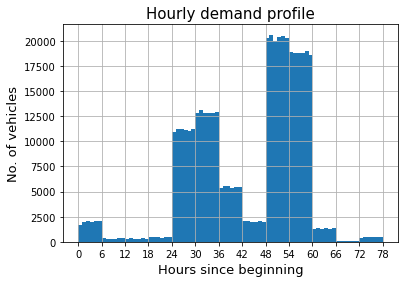

In [10]:
plot_demand_profile(demand)

### Process all demand scenarios

In [11]:
%%time
# create combined demand table
D = pd.DataFrame()

# process all demand files and export their cleaned versions
for scenario in ['base'] + [f'S{i+1}' for i in range(12)]:
    print(scenario)
    # read the demand in wide format
    dmd = process_demand(scenario)
    
    # add it to the overall demand table along with scenario name
    sc_num = 0 if scenario == 'base' else int(scenario[1:])
    dmd.insert(0, 'scenario', sc_num)
    D = D.append(dmd, ignore_index=True)
    
    # convert to long format and export
    to_long(demand) # do not export
#     to_long(demand, outfile=f'demand/Shen-scenarios/{scenario}_clean.csv')
    
D = D.astype({'scenario': 'category', 'veh_id': np.int32, 'dep_time': np.int32,
              'orig': np.int16, 'dest': np.int16, 'is_shelter': bool})
peek(D)

base
S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
Shape: (5972080, 6)
CPU times: user 14.1 s, sys: 3.58 s, total: 17.7 s
Wall time: 18.2 s


,scenario,veh_id,dep_time,orig,is_shelter,dest
0,0,1,1,649,False,141
1,0,2,1,452,False,145
2,0,3,1,178,False,326


In [12]:
peek(D)

Shape: (5972080, 6)


,scenario,veh_id,dep_time,orig,is_shelter,dest
0,0,1,1,649,False,141
1,0,2,1,452,False,145
2,0,3,1,178,False,326


### Get OD matrix

In [13]:
# unique IDs of the zones and shelters combined;
# used to construct the OD matrix
zone_ids = zones.append(shelts, ignore_index=True)['FID'].sort_values().values
print(zone_ids.size)

786


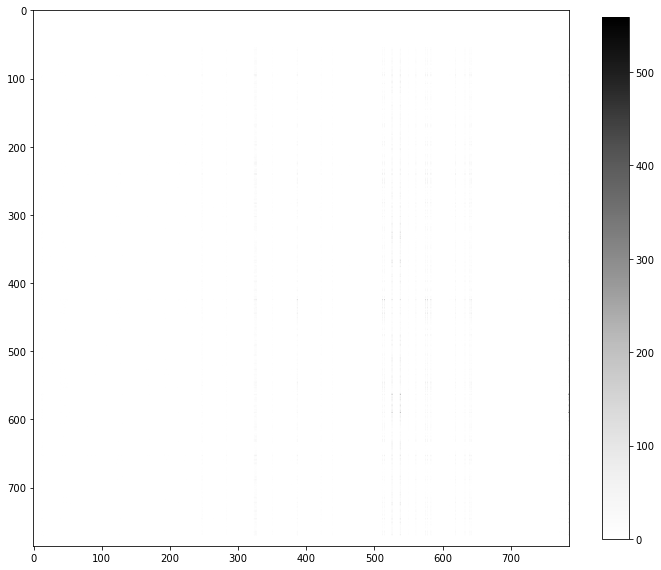

In [14]:
def create_od_mat(demand, zone_ids=zone_ids, plot=False):
    """
    Create an origin-destination (OD) demand matrix from a given demand table
    using a networkx graph.
    """
    # create the graph with all the nodes (zones+shelters)
    G = nx.DiGraph()
    G.add_nodes_from(zone_ids)
    
    # create the edge table
    edges = (demand.groupby(['orig', 'dest']).size()
             .rename('nVeh').reset_index().astype(np.int32).values)
    
    # add the edges to the graph
    for e in edges:
        G.add_edge(e[0], e[1], weight=e[2])
    
    # conver the sparse adjacency matrix to full NxN matrix (N = no. of nodes)
    A = nx.adjacency_matrix(G).A
    
    # plot the image
    if plot:
        fig, ax = plt.subplots(figsize=(12, 12))
        p = ax.imshow(A, cmap='Greys')
        fig.colorbar(p, ax=ax, shrink=0.8)
    
    return pd.DataFrame(A, columns=zone_ids, index=zone_ids)

_ = create_od_mat(demand, plot=True)

### Get OD distribution
Plot the histogram of OD demand where x-axis is the OD ID and y-axis is the demand of that OD pair. Select only the top few most popular OD pairs across all the scenarios.

In [17]:
def compare_num_od(D):
    """
    Compare the no. of OD pairs and total demand by scenario.
    """
    D = D.assign(sc_num = lambda x: x['scenario'].cat.codes)
    num_ods = []
    tot_dmd = []
    for sc_num, df in D.groupby('sc_num'):
        od_dmd = df.groupby(['orig', 'dest']).size().rename('nVeh')
        num_ods.append(od_dmd.size)
        tot_dmd.append(od_dmd.sum())
    
    return num_ods, tot_dmd
    
_ = compare_num_od(D)

CPU times: user 2.45 s, sys: 437 ms, total: 2.88 s
Wall time: 2.89 s


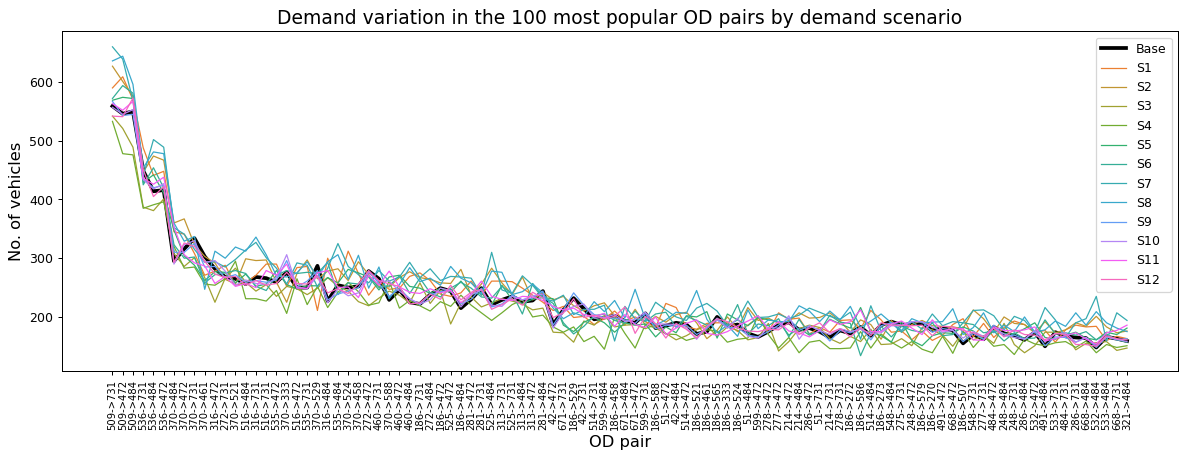

In [15]:
%%time
def plot_od_distr(D, top=100, figsize=(16, 5)):
    """
    Use the table containing the demand of all the scenarios and plot the
    histogram of the top few most popular OD pairs.
    """
    # get the list of all-scenario popular OD pairs
    pop_ods = (D.groupby(['orig', 'dest']).size().rename('nVeh')
               .sort_values(ascending=False).head(top).index)
    
    # now filter these ODPs in all of the scenarios
    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    
    colors = sns.color_palette('husl', len(D.groupby('scenario')))
    
    for (scenario, df), color in zip(D.groupby('scenario'), colors):
        # get the demand table for this scenario
        dmd = df.groupby(['orig', 'dest']).size().rename('nVeh')
        # filter only the popular ODPs
        dmd = dmd.loc[pop_ods].reset_index()
        # format the OD pair labels
        dmd['od_id'] = dmd['orig'].astype(str) + '->' + dmd['dest'].astype(str)
        
        # plot the demand by ODP
        if scenario == 0: # special formatting for base scenario
            color, linewidth, sc_name = 'black', 3, 'Base'
        else:
            linewidth, sc_name = 1, f'S{scenario}'
        # calculate the total demand & no. of ODs in this scenario to be added to label
        od_dmd = D[D['scenario'] == scenario].groupby(['orig', 'dest']).size()
#         print(sc_name, od_dmd.size, od_dmd.sum())
#         label = f'{sc_name} (N={od_dmd.size:,}, Q={od_dmd.sum()/1e3:.0f}k)'
        label = sc_name
                    
        ax.plot(dmd['od_id'], dmd['nVeh'], color=color, lw=linewidth, label=label)
        
        # format the xticks
        ticks_loc = ax.get_xticks()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(dmd['od_id'], rotation=90, fontsize=8)
    ax.legend()
    plt.title(f'Demand variation in the {top} most popular OD pairs by demand scenario',
              fontsize=15)
    plt.xlabel('OD pair', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)
#     return pop_ods
    
plot_od_distr(D)

In [28]:
# mapping between CBG/TAZ ID and Emmanuel's 7 destination choice zones
# (2 in city, 5 directional)
map_cbg_dir_zone = (pd.read_csv('map_cbg_directional_zone.csv')
                    .rename(columns=lambda x: x.lower())
                    .rename(columns={'destchoice': 'em_zone', 'taz.x': 'cbg'}))
peek(map_cbg_dir_zone)

Shape: (618238, 6)


,household_id,evacdecision,depature,vehicle,em_zone,cbg
0,1,0,36,1,1,120030401011
1,2,1,36,1,4,120030401011
2,3,1,54,1,4,120030401011


In [22]:
map_cbg_dir_zone.groupby(['em_zone', 'cbg']).size().rename('demand').reset_index()

,em_zone,cbg,demand
0,1,120030401011,362
1,1,120030401012,240
2,1,120030401013,122
3,1,120030401021,98
4,1,120030401022,236
...,...,...,...
4969,7,121090214062,48
4970,7,121090214071,69
4971,7,121259601001,11
4972,7,121259601002,15


In [25]:
map_cbg_dir_zone.cbg.unique().size

711

In [26]:
map_cbg_dir_zone.groupby('EVACDECISION')

618238